# Human Activity Recognition - GNP Shared Bottleneck

Last Update : 21 July 2019

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = True # can also be set in the trainer

## Environment

In [2]:
cd ..

/conv


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd
import h5py


import torch
torch.set_num_threads(N_THREADS)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
          'figure.titlesize': 'x-large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

Autosaving every 600 seconds


# Dataset

In [4]:
from skssl.transformers.neuralproc.datasplit import CntxtTrgtGetter, GetRandomIndcs, get_all_indcs
from utils.data.tsdata import get_timeseries_dataset, SparseMultiTimeSeriesDataset

get_cntxt_trgt_test = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.1, max_n_indcs=0.5),
                                     targets_getter=get_all_indcs,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

get_cntxt_trgt_feat = CntxtTrgtGetter(contexts_getter=get_all_indcs,
                                     targets_getter=get_all_indcs,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes


get_cntxt_trgt = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=0.5),
                                 targets_getter=GetRandomIndcs(min_n_indcs=0.5, max_n_indcs=0.99),
                                 is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

In [5]:
data_train = get_timeseries_dataset("har")(split="train")
data_test = get_timeseries_dataset("har")(split="test")
data_both = get_timeseries_dataset("har")(split="both")

def cntxt_trgt_collate(get_cntxt_trgt, is_repeat_batch=False):
    def mycollate(batch):
        min_length = min([v.size(0) for b in batch for k,v in b[0].items() if "X" in k])
        # chose first min_legth of each (assumes that randomized)
        
        batch = [({k:v[:min_length, ...] for k,v in b[0].items()}, b[1]) for b in batch]        
        collated = torch.utils.data.dataloader.default_collate(batch)
        
        X = collated[0]["X"]
        y = collated[0]["y"]
        
        if is_repeat_batch:
            
            X = torch.cat([X,X], dim=0)
            y = torch.cat([y,y], dim=0)
        
        collated[0]["X"], collated[0]["y"], collated[0]["X_trgt"], collated[0]["y_trgt"] = get_cntxt_trgt(X, y)
        
        return collated
    return mycollate

In [6]:
X_DIM = 1  # 1D spatial input (although actually 2 but the first is for sparse channels)
Y_DIM = data_train.data.shape[-1] # multiple channels
N_TARGETS = len(np.unique(data_train.targets))

sampling_percentages = [0.05, 0.1, 0.3, 0.5, 0.7, 1]
label_percentages = [N_TARGETS, N_TARGETS*2, 0.01, 0.05, 0.1, 0.3, 0.5]

## Model

In [7]:
import torch.nn as nn
from skssl.transformers import GlobalNeuralProcess, NeuralProcessLoss, AttentiveNeuralProcess
from skssl.utils.helpers import rescale_range
from skssl.predefined import UnetCNN, CNN, MLP, SparseSetConv, SetConv, MlpRBF, GaussianRBF, BatchSparseSetConv
from skssl.transformers.neuralproc.datasplit import precomputed_cntxt_trgt_split
from utils.helpers import count_parameters

In [8]:
from copy import deepcopy

models = {}

unet = partial(UnetCNN,
               Conv=torch.nn.Conv1d,
               Pool=torch.nn.MaxPool1d,
               upsample_mode="linear",
               n_layers=18,
               is_double_conv=True,
               is_depth_separable=True,
               Normalization=torch.nn.BatchNorm1d,
               is_chan_last=True,
               bottleneck=None,
               kernel_size=7,
               max_nchannels=256,
              is_force_same_bottleneck=True
              )

kwargs = dict(x_dim=X_DIM, 
              y_dim=Y_DIM,
              min_std=5e-3,
                n_tmp_queries=128,
                r_dim=64,
              keys_to_tmp_attn=partial(SetConv, RadialBasisFunc=GaussianRBF),
              TmpSelfAttn=unet,
              tmp_to_queries_attn=partial(SetConv, RadialBasisFunc=GaussianRBF),
              is_skip_tmp=False,
              is_use_x=False,
              get_cntxt_trgt=precomputed_cntxt_trgt_split,
              is_encode_xy=False)

models["transformer_gnp_large_shared_bottleneck"] = partial(GlobalNeuralProcess, **kwargs)


In [9]:
from utils.helpers import count_parameters
for k,v in models.items():
    print(k, "- N Param:", count_parameters(v()))

transformer_gnp_large_shared_bottleneck - N Param: 1006936


# Training

In [10]:
from ntbks_helpers import train_models_
from skorch.dataset import CVSplit

In [11]:
N_EPOCHS = 100 
BATCH_SIZE = 32
IS_RETRAIN = False # if false load precomputed
chckpnt_dirname="results/challenge/har/"

In [12]:
data_trainers = {}
datas = {p:get_timeseries_dataset("har")(split="both", data_perc=p, is_fill_mean=False)
         for p in sampling_percentages}

for p,data in datas.items():
    data_trainers.update(train_models_({"{}%har".format(int(p*100)): data}, 
                              models, 
                              NeuralProcessLoss,
                             patience=15,
                              chckpnt_dirname=chckpnt_dirname,
                              max_epochs=N_EPOCHS,
                              batch_size=BATCH_SIZE,
                              is_retrain=IS_RETRAIN,
                              callbacks=[],
                              train_split=CVSplit(0.05),
                              iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, is_repeat_batch=True),  
                              iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt_test),
                              mode="transformer"))


--- Loading 5%har/transformer_gnp_large_shared_bottleneck ---

5%har/transformer_gnp_large_shared_bottleneck best epoch: 98 val_loss: -2.164531707763672

--- Loading 10%har/transformer_gnp_large_shared_bottleneck ---

10%har/transformer_gnp_large_shared_bottleneck best epoch: 86 val_loss: -2.98053588682008

--- Loading 30%har/transformer_gnp_large_shared_bottleneck ---

30%har/transformer_gnp_large_shared_bottleneck best epoch: 87 val_loss: -4.5797279249117215

--- Loading 50%har/transformer_gnp_large_shared_bottleneck ---

50%har/transformer_gnp_large_shared_bottleneck best epoch: 72 val_loss: -5.531349883959131

--- Loading 70%har/transformer_gnp_large_shared_bottleneck ---

70%har/transformer_gnp_large_shared_bottleneck best epoch: 98 val_loss: -7.103462460897501

--- Loading 100%har/transformer_gnp_large_shared_bottleneck ---

100%har/transformer_gnp_large_shared_bottleneck best epoch: 86 val_loss: -8.16725208180622


# Featurizing

In [13]:
def save_transformed_data(chckpnt_dirname, data_trainers, datas):
    for k, trainer in data_trainers.items():
        perc = float(k.split("%")[0]) / 100
        model_name = k.split("/")[1]
        data = datas[perc]
        trainer.set_params(iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt_feat),
                           iterator_valid__shuffle=False) # make sure not shuffling because only transforming X
        transformed_data = trainer.transform(data)
        np.save(chckpnt_dirname+k+"/transformed_data.npy", transformed_data, allow_pickle=False)

In [14]:
#save_transformed_data(chckpnt_dirname, data_trainers, datas)
# saving all transformed data

# Evaluation

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [16]:
import torch.nn as nn
from skssl.predefined import RNN, MLP

In [17]:
class FeatureMLP(nn.Module):

    def __init__(self, feat_size, y_dim, output_size, **kwargs):
        super().__init__()
        self.out = MLP(feat_size+y_dim*4, output_size, **kwargs)

    def forward(self, X, X_feat, y=None):

        if y is not None:
            # is there's y then that's the actual input and X is time
            X = y

        outputs = self.out(torch.cat([X_feat, X.mean(-2), X.max(-2)[0], X.min(-2)[0], X.var(-2)], dim=-1))
        return outputs

In [18]:
models = dict(mlp_hand = partial(FeatureMLP, feat_size=256, y_dim=Y_DIM, output_size=N_TARGETS, hidden_size=128, 
                dropout=0.5, n_hidden_layers=3, is_res=True))

In [19]:
from utils.helpers import count_parameters
for k,v in models.items():
    print(k, "- N Param:", count_parameters(v()))

mlp_hand - N Param: 71302


In [20]:
from skorch.dataset import Dataset

In [21]:
def train_eval_on_featurized(X_train, X_test, Y_train, Y_test):
    mlp = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(128,))
    mlp = SVC()
    mlp.fit(X_train, Y_train)
    print(mlp.score(X_test, Y_test))

In [22]:
data_trainers_feat = {}

for k, trainer in data_trainers.items():
    perc = float(k.split("%")[0]) / 100
    n_train = datas[perc].n_train
    model_name = k.split("/")[1]
    y = datas[perc].targets
    transformed_data = np.load(chckpnt_dirname+k+"/transformed_data.npy", allow_pickle=False)
    #trainer.module_.cuda()
    #trainer.set_params(iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt_feat), iterator_valid__shuffle=False) # make sure not shuffling because only transforming X
    #transformed_data = trainer.transform(datas[perc])
    
    X_train, X_test, Y_train, Y_test = transformed_data[:n_train], transformed_data[n_train:], y[:n_train].squeeze(), y[n_train:].squeeze()
    
    #train_eval_on_featurized(X_train, X_test, Y_train, Y_test)
                                               
    data_trainers_feat.update(train_models_({"{}%har".format(int(perc*100)): (Dataset(X={"X_feat":X_train.astype(np.float32), 
                                                                   "X":datas[perc].data[:n_train].astype(np.float32)}, 
                                                                y=torch.from_numpy(Y_train).long()), 
                                                        Dataset(X={"X_feat":X_test.astype(np.float32), 
                                                                   "X":datas[perc].data[n_train:].astype(np.float32)}, 
                                                                y=torch.from_numpy(Y_test).long()))}, 
                                               {model_name +"/feat_"+ name: partial(m, feat_size=X_train.shape[-1]) for name,m in models.items()}, 
                                                 chckpnt_dirname=chckpnt_dirname,
                                                  max_epochs=N_EPOCHS,
                                                  batch_size=BATCH_SIZE,
                                                 is_retrain=IS_RETRAIN,
                                                callbacks=[]))
    
    
# 100%: MLP 0.8235 (no feat)
# 
    


--- Loading 5%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

5%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 73 val_loss: 0.38785125635258416

--- Loading 10%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

10%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 44 val_loss: 0.31841600827131994

--- Loading 30%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

30%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 43 val_loss: 0.17624642762403225

--- Loading 50%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

50%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 14 val_loss: 0.16361097501502977

--- Loading 70%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

70%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 21 val_loss: 0.12425847081032582

--- Loading 100%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand --

In [23]:
for k,t in data_trainers_feat.items():
    for e, h in enumerate(t.history[::-1]):
        if h["valid_loss_best"]:
            print(k, "epoch:", len(t.history)-e, 
                  "val_loss:", h["valid_loss"], 
                  "val_acc:", h["valid_acc"])
            break

5%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand epoch: 73 val_loss: 0.38785125635258416 val_acc: 0.8449270444519851
10%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand epoch: 44 val_loss: 0.31841600827131994 val_acc: 0.8791991856124872
30%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand epoch: 43 val_loss: 0.17624642762403225 val_acc: 0.9287410926365796
50%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand epoch: 14 val_loss: 0.16361097501502977 val_acc: 0.9324737020699015
70%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand epoch: 21 val_loss: 0.12425847081032582 val_acc: 0.9609772650152698
100%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand epoch: 15 val_loss: 0.15051334091150279 val_acc: 0.9416355615880556


# Unsupervised Pretraining Evaluation

In [24]:
from utils.data.helpers import make_ssl_dataset_
from utils.data.ssldata import get_train_dev_test_ssl
from skssl.training.loaders import get_supervised_iterator

In [ ]:
data_trainers_feat_unsup = {}

for k, trainer in data_trainers.items():
    if "50%" not in k: #and "100%" not in k:
        continue # only 100%  and 50% for now
    
    for label_perc in label_percentages:
        samplig_perc = float(k.split("%")[0]) / 100
        n_train = datas[samplig_perc].n_train
        model_name = k.split("/")[1]
        data_train, _, data_test = get_train_dev_test_ssl("har", n_labels=label_perc, 
                                                          data_perc=samplig_perc, 
                                                          dev_size=0,
                                                          transformed_file=chckpnt_dirname+k+"/transformed_data.npy")

        print((torch.from_numpy(Y_train).long() != -1).sum())
        X_train, X_test, Y_train, Y_test = data_train.data, data_test.data, data_train.targets.squeeze(), data_test.targets.squeeze()

        data_trainers_feat_unsup.update(train_models_({"{}%har_{}%lab".format(int(samplig_perc*100), int(label_perc*100)): (Dataset(X={"X_feat":X_train.astype(np.float32), 
                                                                       "X":datas[samplig_perc].data[:n_train].astype(np.float32)}, 
                                                                    y=torch.from_numpy(Y_train).long()), 
                                                            Dataset(X={"X_feat":X_test.astype(np.float32), 
                                                                       "X":datas[samplig_perc].data[n_train:].astype(np.float32)}, 
                                                                    y=torch.from_numpy(Y_test).long()))}, 
                                                   {model_name +"/feat_"+ name: partial(m, feat_size=X_train.shape[-1]) for name,m in models.items()}, 
                                                     chckpnt_dirname=chckpnt_dirname,
                                                      max_epochs=N_EPOCHS,
                                                      batch_size=BATCH_SIZE,
                                                     is_retrain=IS_RETRAIN,
                                                   iterator_train=get_supervised_iterator,
                                                     callbacks=[]))


In [ ]:
for k,t in data_trainers_feat_unsup.items():
    print()
    for e, h in enumerate(t.history[::-1]):
        if h["valid_loss_best"]:
            print(k, "epoch:", len(t.history)-e, 
                  "val_loss:", h["valid_loss"], 
                  "val_acc:", h["valid_acc"])
            break

# SSL Evaluation

In [ ]:
from skssl.classifiers import LabelSpreading
from joblib import dump, load
from skssl.meta import SelfTrainingMeta
from sklearn.neural_network import MLPClassifier

## Label Spreading

Also tried self training but did not work well

In [ ]:
for k, trainer in data_trainers.items():
    if "50%" not in k: #and "100%" not in k:
        continue # only 100%  and 50% for now
        
    for label_perc in label_percentages:
        samplig_perc = float(k.split("%")[0]) / 100
        n_train = datas[samplig_perc].n_train
        model_name = k.split("/")[1]
        
        data_train, _, data_test = get_train_dev_test_ssl("har", n_labels=label_perc, 
                                                              data_perc=samplig_perc, 
                                                              dev_size=0,
                                                              transformed_file=chckpnt_dirname+k+"/transformed_data.npy")
        
        X_test = np.concatenate([data_test.data, 
                                 datas[samplig_perc].data[n_train:].mean(1), 
                                  datas[samplig_perc].data[n_train:].min(1), 
                                 datas[samplig_perc].data[n_train:].max(1), 
                                  datas[samplig_perc].data[n_train:].std(1)], axis=-1)
        
        file = chckpnt_dirname+"{}%har_{}%lab/{}/feature_labelspread.joblib".format(int(samplig_perc*100), int(label_perc*100), model_name)

        if IS_RETRAIN:
            X_train = np.concatenate([data_train.data, 
                                      datas[samplig_perc].data[:n_train].mean(1), 
                                      datas[samplig_perc].data[:n_train].min(1), 
                                      datas[samplig_perc].data[:n_train].max(1), 
                                      datas[samplig_perc].data[:n_train].std(1)], axis=-1)
            Y_train = data_train.targets.flatten()
            Y_test_unsup = -1*np.ones_like(data_test.targets.flatten())
        
            clf = LabelSpreading(kernel="rbf", gamma=4.001, n_jobs=-1, max_iter=50, alpha=0.1565)
            clf.fit(np.concatenate([X_train, X_test], axis=0),  
                    np.concatenate([Y_train, Y_test_unsup], axis=0))
            dump(clf, file)

        else:

            clf = load(file)
            
        
        print("Label Spreading on {}% of data".format(label_perc*100), 
              clf.score(X_test, data_test.targets.flatten()))

In [52]:
from skopt import BayesSearchCV

data_trainers = {}
samplig_perc = 0.5

for label_perc in [1]:
    samplig_perc = float(k.split("%")[0]) / 100
    n_train = datas[samplig_perc].n_train
    model_name = k.split("/")[1]

    data_train, _, data_test = get_train_dev_test_ssl("har", n_labels=label_perc, 
                                                          data_perc=samplig_perc, 
                                                          dev_size=0,
                                                          transformed_file=chckpnt_dirname+k+"/transformed_data.npy")

    X_test = np.concatenate([data_test.data, 
                             datas[samplig_perc].data[n_train:].mean(1), 
                             datas[samplig_perc].data[n_train:].min(1), 
                             datas[samplig_perc].data[n_train:].max(1), 
                             datas[samplig_perc].data[n_train:].std(1)], axis=-1)
    
    X_train = np.concatenate([data_train.data, 
                              datas[samplig_perc].data[:n_train].mean(1), 
                              datas[samplig_perc].data[:n_train].min(1), 
                              datas[samplig_perc].data[:n_train].max(1), 
                              datas[samplig_perc].data[:n_train].std(1)], axis=-1)

    clf = LabelSpreading(max_iter=50)
    
    bcv = BayesSearchCV(clf, clf.get_hypopt_search_space())
    
    
    bcv.fit(X_train, data_train.targets.flatten())
        
   
    print("Label Spreading on {}% of data".format(label_perc*100), 
          bcv.score(X_test, data_test.targets.flatten()))
    

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


KeyboardInterrupt: 

In [31]:
bcv.best_params_

{'alpha': 0.15645696272804752, 'gamma': 4.001047472476528, 'kernel': 'rbf'}

In [27]:
eg = 300
data = data_train
n_cntxts = 100

idcs = torch.randperm(128)[:n_cntxts]
X_cntxt = data[eg][0]["X"][idcs].unsqueeze(0)
Y_cntxt = data[eg][0]["y"][idcs].unsqueeze(0)

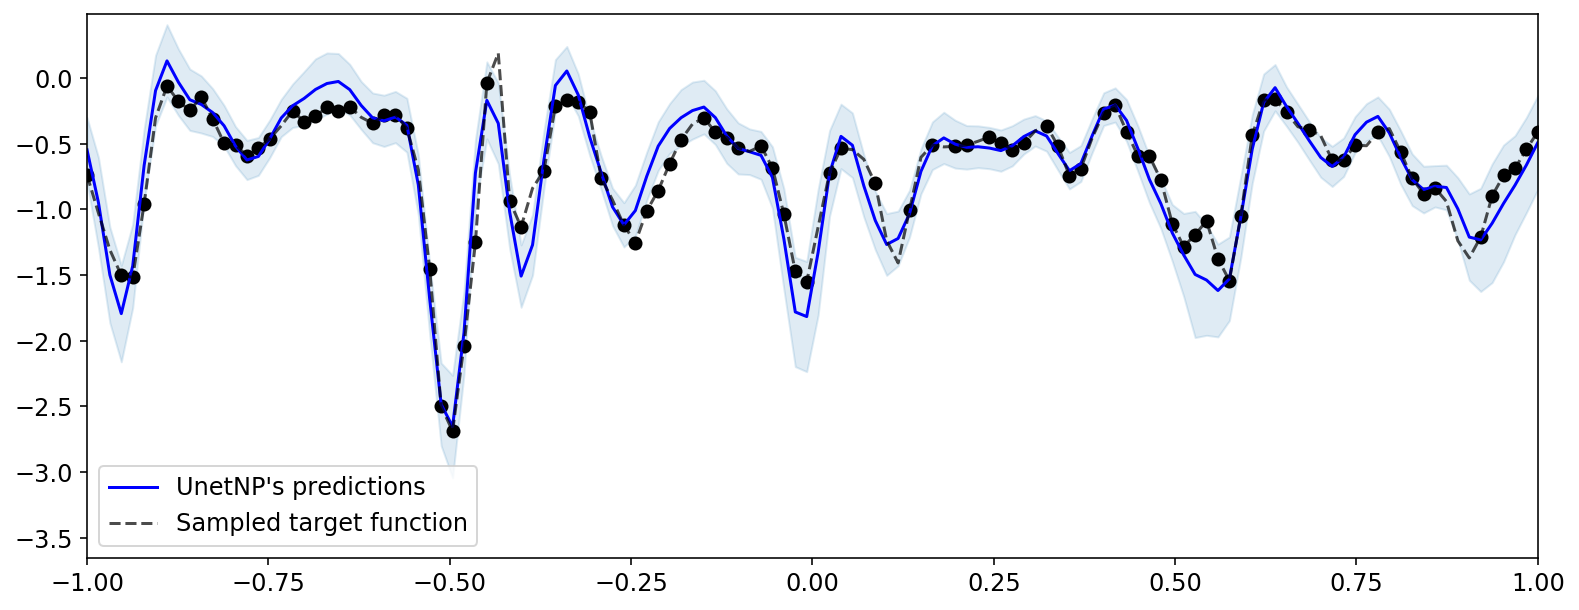

In [32]:
from ntbks_viz import plot_posterior_predefined_cntxt
plot_posterior_predefined_cntxt(data_trainers['100%har/transformer_gnp_large_shared_bottleneck'].module_, 
                                true_func=(data[eg][0]["X"].unsqueeze(0), data[eg][0]["y"].unsqueeze(0)),
                               X_cntxt=X_cntxt, 
                               Y_cntxt=Y_cntxt,
                               n_trgt=128,
                               n_samples=1,
                               is_plot_std=True,
                               train_min_max=(-1,1),
                                model_label='UnetNP',
                                figsize=(13,5),
                               title=None,
                                       y_idx=7)

In [ ]:
from skopt.space import Real, Categorical, Integer

params = {
    'module__x_dim': [X_DIM],
    'module__y_dim': [Y_DIM],
    'module__r_dim': [8,16,32,64],
    #'module__keys_to_tmp_attn__RadialBasisFunc': [MlpRBF, GaussianRBF],
    #'module__TmpSelfAttn__is_depth_separable': Categorical([True,False]),
}

def scorer(model, X, y=None):
    score = 0
    n_steps = 0
    
    dataset = model.get_dataset(X, y)

    # use th eloss as metric (i.e. return log likelihood)
    model.criterion_.is_use_as_metric = True
    
    valid_batch_count = 0
    for Xi, yi in model.get_iterator(dataset, training=False):
        n_steps += 1
        yi_res = yi 
        step = model.validation_step(Xi, yi)
        score += step["loss"].item()
        
    score /= n_steps
    
    return score

gs = BayesSearchCV(model, 
                   params, 
                   refit=False, 
                   cv=3, 
                   scoring=scorer)

gs.fit(skorch.helper.SliceDataset(data_train))
print(gs.best_score_, gs.best_params_)